In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import h5py
import gc
import math

# third-party toolkits for the first implementation to see what the results look like, 
# will implement the K-Means by my self following the first implementation
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM, GMMHMM

In [2]:
num_state = 8
num_mix = 3

In [3]:
num_features_after_pca = 60

In [4]:

#read data
data_set_folder = 'new data set/Data_set_no_EEG_step_1.0_3PCA_3x20_intact/'
x_path = data_set_folder + 'x_matrix.mat'
x_matrix_mat = h5py.File(x_path, mode='r')
x_matrix = np.transpose(x_matrix_mat['x_matrix'][:].astype(np.float32))
num_features, num_samples_of_each_subject = x_matrix.shape

TN_subjectNum = 22
subject_num_list_for_test = [21, 22] #change every time


# construct the training set
are_training_sets_not_initialized = True
for subject_num in range(1, TN_subjectNum + 1):
    print('Processing subject #', subject_num)
    if subject_num in subject_num_list_for_test:
            continue
    subject_num_str = str(subject_num + 100000)[-2:]
    y_path = data_set_folder + 'sj_' + subject_num_str + '_Y.mat'
    y_list_mat = h5py.File(y_path, mode='r')
    y_list = np.transpose(y_list_mat['y_list'][:].astype(np.float32))

    # balance the samples of each subject
    count0 = 0
    count1 = 0
    for i in range(len(y_list)):
        if y_list[i][0] == 0:
            count0 = count0 + 1
        else:
            count1 = count1 + 1

    x_matrix_y0 = np.zeros((num_features, count0))
    x_matrix_y1 = np.zeros((num_features, count1))
    x_matrix_y0_pointer = 0
    x_matrix_y1_pointer = 0

    for column_num in range(num_samples_of_each_subject):
        x_sample = x_matrix[:, column_num]
        if y_list[column_num][0] == 0:
            x_matrix_y0[:, x_matrix_y0_pointer] = x_sample
            x_matrix_y0_pointer = x_matrix_y0_pointer + 1
        else:
            x_matrix_y1[:, x_matrix_y1_pointer] = x_sample
            x_matrix_y1_pointer = x_matrix_y1_pointer + 1

    # shuffle all columns of x_matrix_y0
    perm = np.arange(count0)
    np.random.shuffle(perm)
    x_matrix_y0 = x_matrix_y0.T[perm]
    x_matrix_y0 = x_matrix_y0.T

    # shuffle all columns of x_matrix_y1
    perm = np.arange(count1)
    np.random.shuffle(perm)
    x_matrix_y1 = x_matrix_y1.T[perm]
    x_matrix_y1 = x_matrix_y1.T

    if count0 < count1:
        x_matrix_y1 = x_matrix_y1[:, :count0]
    else:
        x_matrix_y0 = x_matrix_y0[:, :count1]

    if are_training_sets_not_initialized:
        training_set_y0 = x_matrix_y0
        training_set_y1 = x_matrix_y1
        are_training_sets_not_initialized = False
    else:
        training_set_y0 = np.hstack((training_set_y0, x_matrix_y0))
        training_set_y1 = np.hstack((training_set_y1, x_matrix_y1))



Processing subject # 1
Processing subject # 2
Processing subject # 3
Processing subject # 4
Processing subject # 5
Processing subject # 6
Processing subject # 7
Processing subject # 8
Processing subject # 9
Processing subject # 10
Processing subject # 11
Processing subject # 12
Processing subject # 13
Processing subject # 14
Processing subject # 15
Processing subject # 16
Processing subject # 17
Processing subject # 18
Processing subject # 19
Processing subject # 20
Processing subject # 21
Processing subject # 22


In [5]:
#run with 4000 samples from y0 and y1
# training_set_y0 = training_set_y0[:, 0:2000] 
# training_set_y1 = training_set_y1[:, 0:2000]

In [6]:
y0_feature_list = []
for sample_n in range(len(training_set_y0[0])):
    features = np.reshape(training_set_y0[:, sample_n], (num_features_after_pca, -1), 'F')
    y0_feature_list.append(features)
del training_set_y0
gc.collect()

y1_feature_list = []
for sample_n in range(len(training_set_y1[0])):
    features = np.reshape(training_set_y1[:, sample_n], (num_features_after_pca, -1), 'F')
    y1_feature_list.append(features)
del training_set_y1
gc.collect()

0

In [7]:
len(y0_feature_list)

11000

In [8]:
y1_feature_list[0].shape

(60, 343)

In [9]:
# training HMM


startprob = np.zeros(num_state)
startprob[0] = 1

# transition matrix
# transition_matrix = np.array([
#     [0.5, 0.5, 0, 0, 0, 0],
#     [0, 0.5, 0.5, 0, 0, 0],
#     [0, 0, 0.5, 0.5, 0, 0],
#     [0, 0, 0, 0.5, 0.5, 0],
#     [0, 0, 0, 0, 0.5, 0.5],
#     [0, 0, 0, 0, 0, 1.0]
# ])

# Single directional transition matrix
transition_matrix = np.zeros((num_state, num_state))
for i in range(num_state - 1):
    transition_matrix[i, i] = 0.5
    transition_matrix[i, i+1] = 0.5
transition_matrix[-1,-1] =1


list_hmm_models = [] # store each model for one of the two classes
for y_label in range(2): # for class y=0 and y=1
    print('Training for class y =', y_label)
    
    if y_label == 0:
        feature_matrix_list = y0_feature_list
    else:
        feature_matrix_list = y1_feature_list
    
    
    is_the_first_matrix = True
    list_lengths = []
    list_matrix_parts_mfcc_features = [] # for initializing different states by different part of the sequence of frames
    
    count_processed = 0
    for feature_matrix in feature_matrix_list:
        mfcc_matrix = feature_matrix
        mfcc_feature_num, mfcc_length = mfcc_matrix.shape
        list_lengths.append(mfcc_length)

        list_feature_parts_starting_column_nums = np.floor(np.linspace(0, mfcc_length, num_state + 1))
        list_feature_parts_starting_column_nums = list_feature_parts_starting_column_nums.astype(np.int)
        if is_the_first_matrix:
            matrix_all_mfcc_features = mfcc_matrix
            for state_num in range(num_state):
                list_matrix_parts_mfcc_features.append(
                    mfcc_matrix[:, 
                                list_feature_parts_starting_column_nums[state_num] : 
                                list_feature_parts_starting_column_nums[state_num + 1]]
                )

            is_the_first_matrix = False
        else:
            matrix_all_mfcc_features = np.hstack((matrix_all_mfcc_features, mfcc_matrix))
            for state_num in range(num_state):
                part_of_matrix = mfcc_matrix[:, list_feature_parts_starting_column_nums[state_num] : list_feature_parts_starting_column_nums[state_num + 1]]
                list_matrix_parts_mfcc_features[state_num] = np.hstack((list_matrix_parts_mfcc_features[state_num], part_of_matrix))
        count_processed = count_processed + 1
        if count_processed % 100 == 0:
            print('Processed', count_processed, 'out of', len(feature_matrix_list))
    # this time, I initialize the HMM's each state model by the parameters of a GMM
    # each GMM is trained on a different part of the sequence of frames, with the order of the corresponding state
    # e.g., if the number of states is 4, then the feaeture frames of each sample will be divided into 4 parts,
    # then the GMM for the second state is only trained on the data of the second part of each sample
    list_gmm_models = []
    for state_num in range(num_state):
        gmm_model = GaussianMixture(n_components=num_mix, covariance_type='diag', random_state=12345).fit(list_matrix_parts_mfcc_features[state_num].T)
        list_gmm_models.append(gmm_model)
    
    # collect the parameters of all GMMs
    
    # initialize gmm_weights, gmm_means and gmm_covariances with correct shapes
    gmm_weights = np.zeros((num_state, num_mix))
    gmm_means = np.zeros((num_state, num_mix, mfcc_feature_num))
    gmm_covariances = np.zeros((num_state, num_mix, mfcc_feature_num))

    # collect parameters
    for state_num in range(num_state):
        w = list_gmm_models[state_num].weights_
        gmm_weights[state_num] = w.reshape(1, num_mix)
        gmm_means[state_num] = list_gmm_models[state_num].means_
        gmm_covariances[state_num] = list_gmm_models[state_num].covariances_
        
    
#     gmm_model = GaussianMixture(n_components=num_mix, covariance_type='diag', random_state=12345).fit(matrix_all_mfcc_features.T)
#     # reshape GMM's parameters
#     gmm_weights = gmm_model.weights_
#     gmm_weights.reshape(1, num_mix)
#     gmm_weights = np.broadcast_to(gmm_weights, (num_state, num_mix))
    
#     gmm_means = np.expand_dims(gmm_model.means_, 0).repeat(num_state, axis=0)
#     gmm_covariances = np.expand_dims(gmm_model.covariances_, 0).repeat(num_state, axis=0)
    
    hmm_model = GMMHMM(n_components = num_state, n_mix=num_mix, n_iter=30, tol=1e-5, 
                       init_params ='', params ="tmcw",
                       covariance_type='diag', min_covar = 0.0001, random_state=12345, verbose=True)

    hmm_model.startprob_ = startprob
    hmm_model.transmat_ = transition_matrix
    hmm_model.weights_ = gmm_weights
    hmm_model.means_ = gmm_means
    hmm_model.covars_ = gmm_covariances

    hmm_model.fit(matrix_all_mfcc_features.T, np.array(list_lengths))
    
    list_hmm_models.append(hmm_model)



Training for class y = 0
Processed 100 out of 11000
Processed 200 out of 11000
Processed 300 out of 11000
Processed 400 out of 11000
Processed 500 out of 11000
Processed 600 out of 11000
Processed 700 out of 11000
Processed 800 out of 11000
Processed 900 out of 11000
Processed 1000 out of 11000
Processed 1100 out of 11000
Processed 1200 out of 11000
Processed 1300 out of 11000
Processed 1400 out of 11000
Processed 1500 out of 11000
Processed 1600 out of 11000
Processed 1700 out of 11000
Processed 1800 out of 11000
Processed 1900 out of 11000
Processed 2000 out of 11000
Processed 2100 out of 11000
Processed 2200 out of 11000
Processed 2300 out of 11000
Processed 2400 out of 11000
Processed 2500 out of 11000
Processed 2600 out of 11000
Processed 2700 out of 11000
Processed 2800 out of 11000
Processed 2900 out of 11000
Processed 3000 out of 11000
Processed 3100 out of 11000
Processed 3200 out of 11000
Processed 3300 out of 11000
Processed 3400 out of 11000
Processed 3500 out of 11000
Proc

         1   311034738.0236             +nan
         2   330593541.3867   +19558803.3632
         3   337766309.4959    +7172768.1092
         4   340232993.1641    +2466683.6682
         5   341213892.6714     +980899.5073
         6   341781567.7497     +567675.0783
         7   342106035.6019     +324467.8522
         8   342327918.2353     +221882.6334
         9   342558751.8326     +230833.5973
        10   342751814.5245     +193062.6919
        11   342930339.0675     +178524.5430
        12   343128513.6410     +198174.5735
        13   343271731.8158     +143218.1748
        14   343366293.3254      +94561.5095
        15   343460711.0931      +94417.7677
        16   343539989.5199      +79278.4269
        17   343609339.3755      +69349.8556
        18   343657226.4886      +47887.1131
        19   343699915.3236      +42688.8351
        20   343733860.0863      +33944.7627
        21   343760253.5293      +26393.4430
        22   343789098.9153      +28845.3860
        23

Training for class y = 1
Processed 100 out of 11000
Processed 200 out of 11000
Processed 300 out of 11000
Processed 400 out of 11000
Processed 500 out of 11000
Processed 600 out of 11000
Processed 700 out of 11000
Processed 800 out of 11000
Processed 900 out of 11000
Processed 1000 out of 11000
Processed 1100 out of 11000
Processed 1200 out of 11000
Processed 1300 out of 11000
Processed 1400 out of 11000
Processed 1500 out of 11000
Processed 1600 out of 11000
Processed 1700 out of 11000
Processed 1800 out of 11000
Processed 1900 out of 11000
Processed 2000 out of 11000
Processed 2100 out of 11000
Processed 2200 out of 11000
Processed 2300 out of 11000
Processed 2400 out of 11000
Processed 2500 out of 11000
Processed 2600 out of 11000
Processed 2700 out of 11000
Processed 2800 out of 11000
Processed 2900 out of 11000
Processed 3000 out of 11000
Processed 3100 out of 11000
Processed 3200 out of 11000
Processed 3300 out of 11000
Processed 3400 out of 11000
Processed 3500 out of 11000
Proc

         1   298857350.0655             +nan
         2   320911396.5404   +22054046.4749
         3   327289555.2575    +6378158.7170
         4   329465895.1107    +2176339.8532
         5   330577665.5269    +1111770.4162
         6   331220656.8819     +642991.3551
         7   331676284.3299     +455627.4479
         8   332073659.3776     +397375.0477
         9   332470632.5054     +396973.1278
        10   332757558.4649     +286925.9595
        11   332941038.5260     +183480.0611
        12   333098627.6921     +157589.1661
        13   333232171.4890     +133543.7969
        14   333410393.1078     +178221.6188
        15   333573024.3918     +162631.2839
        16   333712333.5391     +139309.1473
        17   333831561.4262     +119227.8871
        18   333908836.9333      +77275.5071
        19   333967734.5177      +58897.5844
        20   334027991.5554      +60257.0377
        21   334086012.3422      +58020.7868
        22   334123616.7069      +37604.3647
        23

In [10]:
vis_start = 500
vis_end = 660

x_matrix.shape

(20580, 1903)

The accuracy of testing on subject #21 is 0.44508670520231214
The accuracy of testing on subject #22 is 0.46925906463478717
The total accuracy is 0.4571728849185497


<Figure size 432x288 with 0 Axes>

Text(0.5,1,'Ground truth of testing subject # 2')

<Figure size 1800x1200 with 0 Axes>

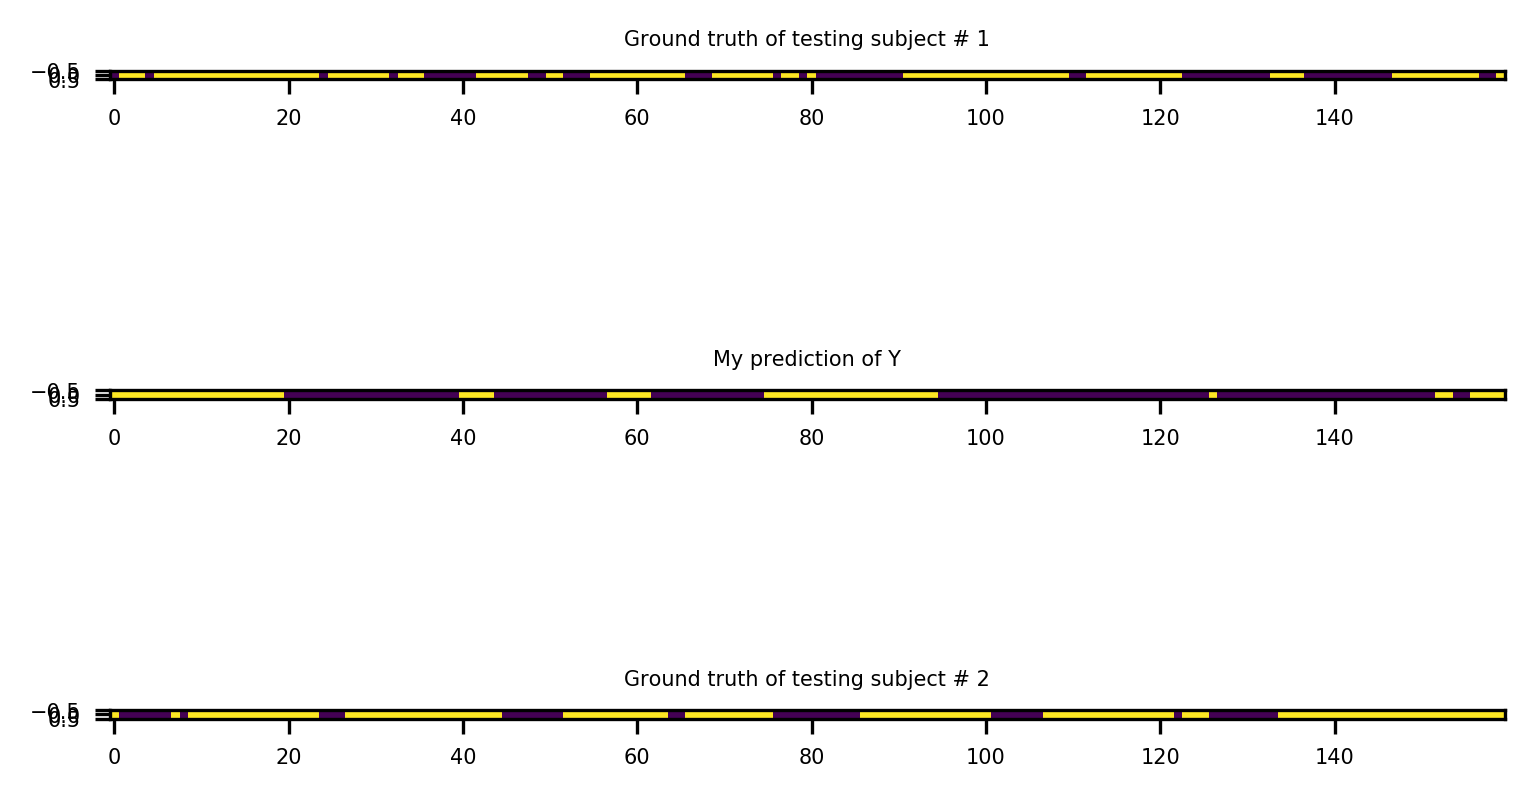

In [11]:
x_matrix_feature_list = []
for sample_n in range(x_matrix.shape[1]):
    features = np.reshape(x_matrix[:, sample_n], (num_features_after_pca, -1), 'F')
    x_matrix_feature_list.append(features)

# predict on x_matrix
prediction_series = []
for test_sample in x_matrix_feature_list:
        list_score = []
        for model in list_hmm_models:
            score = model.score(test_sample.T)
            list_score.append(score)
        prediction = np.argmax(list_score)
        prediction_series.append(prediction)
        
#################################################################
# test

count_correct_total = 0
count_test_total = 0
for subject_num in subject_num_list_for_test:
    subject_num_str = str(subject_num + 100000)[-2:]
    y_path = data_set_folder + 'sj_' + subject_num_str + '_Y.mat'
    y_list_mat = h5py.File(y_path, mode='r')
    y_list = np.transpose(y_list_mat['y_list'][:].astype(np.float32))

    # calculate the accuracy
    count_correct = 0
    for i in range(len(y_list)):
        if y_list[i][0] == prediction_series[i]:
            count_correct = count_correct + 1
    accuracy = count_correct / len(y_list)
    print('The accuracy of testing on subject #' + subject_num_str + ' is ' + str(accuracy))

    count_correct_total = count_correct_total + count_correct
    count_test_total = count_test_total + len(y_list) 


accuracy_total = count_correct_total / count_test_total
print('The total accuracy is', accuracy_total)





# visualize the test results

# repeat some code so that the plot works properly at the first time running this notebook
fig = plt.figure()
plt.rcParams['figure.dpi'] = 300
plt.show()

plt.clf()
fig = plt.figure()
plt.rcParams['figure.dpi'] = 300


# subject 1
plt.subplot(3, 1, 1)

subject_num = subject_num_list_for_test[0]

subject_num_str = str(subject_num + 100000)[-2:]
y_path = data_set_folder + 'sj_' + subject_num_str + '_Y.mat'
y_list_mat = h5py.File(y_path, mode='r')
y_list = np.transpose(y_list_mat['y_list'][:].astype(np.float32))
# obtain the time series of Y
y_time_series = []
for i in range(len(y_list)):
    if y_list[i][0] == 0:
        y_time_series.append(0)
    else:
        y_time_series.append(1)
y_time_series_00 = y_time_series 

y_time_series_array = np.array(y_time_series[vis_start:vis_end])
plt.imshow(y_time_series_array.reshape(1, -1), vmin=0, vmax=1)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
# plt.title('Ground truth of subject #' + subject_num_str)
plt.title('Ground truth of testing subject # 1', fontsize=5)


# the time series of my prediction of Y
plt.subplot(3, 1, 2)
prediction_series_array = np.array(prediction_series[vis_start:vis_end])
plt.imshow(prediction_series_array.reshape(1, -1), vmin=0, vmax=1)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.title('My prediction of Y', fontsize=5)

# subject 2
plt.subplot(3, 1, 3)

subject_num = subject_num_list_for_test[1]

subject_num_str = str(subject_num + 100000)[-2:]
y_path = data_set_folder + 'sj_' + subject_num_str + '_Y.mat'
y_list_mat = h5py.File(y_path, mode='r')
y_list = np.transpose(y_list_mat['y_list'][:].astype(np.float32))
# obtain the time series of Y
y_time_series = []
for i in range(len(y_list)):
    if y_list[i][0] == 0:
        y_time_series.append(0)
    else:
        y_time_series.append(1)
y_time_series_01 = y_time_series 

y_time_series_array = np.array(y_time_series[vis_start:vis_end])
plt.imshow(y_time_series_array.reshape(1, -1), vmin=0, vmax=1)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
# plt.title('Ground truth of subject #' + subject_num_str)
plt.title('Ground truth of testing subject # 2', fontsize=5)